In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

# Restricted Boltzmann Machines

## Energy-based model

Energy-based models associate a scalar energy to each configuration of the variables of interest.

Low energy is more desirable.

The probability distribution based on an energy function can be defined as follows

$$\text{Pr}(x) = \frac{\text{exp}(-E(x))}{Z}$$

where $Z = \Sigma_x \text{exp}(-E(x))$ denotes the normalization factor or partition function.

## Restricted Boltzmann Machine

Restricted Boltzmann Machine (RBM) has an efficient training algorithm.

In order to increase the expressive power of the model, we do not observe the example $x$ fully, we also want to introduce some non-observed variables.

Consider an observed part $x$ and a hidden part $h$.

We can then write:

$$\text{Pr}(x) = \sum_h \frac{\text{exp}(-E(x, h))}{Z}$$

In RBM, the energy function is defined as

$$E(x, h) = -a^Tx - b^T h - x^T Wh$$

To make RBM as an energy-based model, the free energy function is computed as follows

$$\begin{align*} F(x) &= -\text{log}\sum_h \text{exp}(-E(x, h)) \\ &= -a^T x - \sum_j \text{log}(1 + \text{exp}(W_j^T x + b_j)) \end{align*}$$

We have an tractable expression for the conditional probabilities

$$\text{Pr}(h|x) = \prod_i \text{Pr}(h_i | x)$$

In [2]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, k=1):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.v = nn.Parameter(torch.zeros(n_visible))
        self.h = nn.Parameter(torch.zeros(n_hidden))
        self.k = k
    
    def visible_to_hidden(self, v):
        p = torch.sigmoid(F.linear(v, self.W, self.h))

        return p.bernoulli()

    def hidden_to_visible(self, h):
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))

        return p.bernoulli()

    def free_energy(self, v):
        vbias_term = v @ self.v
        wx_h = F.linear(v, self.W, self.h)
        hidden_term = torch.sum(F.softplus(wx_h), dim=1)
        return torch.mean(-hidden_term - vbias_term)

    def forward(self, v):
        h = self.visible_to_hidden(v)

        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v_gibb)

        return v, v_gibb

In [3]:
batch_size = 64
n_epochs = 10
lr = 0.01
n_hid = 128
n_vis = 784

In [4]:
model = RBM(n_vis, n_hid, k=1)

In [6]:
from torchvision import datasets, transforms

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./output", train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])),
    batch_size=batch_size,
)

100%|██████████| 9.91M/9.91M [00:19<00:00, 501kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 51.5kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.51MB/s]


In [9]:
import torch.optim as optim

In [11]:
def train(model, train_loader, n_epochs, lr):
    train_op = optim.Adam(model.parameters(), lr=lr)

    model.train()

    for epoch in range(n_epochs):
        loss_ = []

        for _, (data, target) in enumerate(train_loader):
            v, v_gibbs = model(data.view(-1, 784))
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            loss_.append(loss.item())

            train_op.zero_grad()
            loss.backward()
            train_op.step()

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {sum(loss_)/len(loss_)}")

    return model

In [12]:
model = train(model, train_loader, n_epochs=n_epochs, lr=lr)

Epoch 1/10, Loss: -8.611621041287746
Epoch 2/10, Loss: -2.2371138387651586
Epoch 3/10, Loss: 0.10813793190506729
Epoch 4/10, Loss: 1.4714051757031665
Epoch 5/10, Loss: 2.093719791501824
Epoch 6/10, Loss: 2.4145510089931204
Epoch 7/10, Loss: 2.5236160343389775
Epoch 8/10, Loss: 2.713559734287547
Epoch 9/10, Loss: 2.6867400212074393
Epoch 10/10, Loss: 2.7286144817815914


In [13]:
images = next(iter(train_loader))[0]
v, v_gibbs = model(images.view(-1, 784))

In [14]:
import numpy as np

In [16]:
import matplotlib.pyplot as plt

In [19]:
def show(img, file_name=""):
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(npimg, cmap="gray")

In [20]:
from torchvision.utils import make_grid

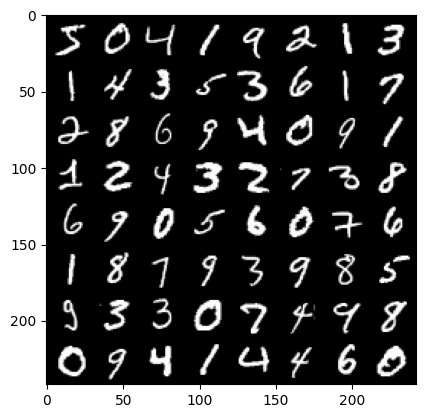

In [21]:
show(make_grid(v.view(batch_size, 1, 28, 28).data))

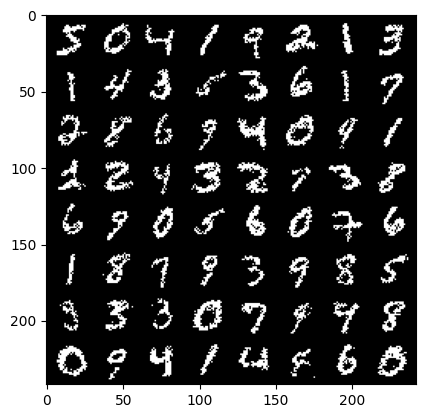

In [22]:
show(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data))

In [23]:
n_sample = 4
kth = 18
d = images[kth:kth+1]

In [24]:
V = torch.sigmoid(F.linear(d.view(1, -1), model.W, model.h))
v, o = torch.sort(V.view(-1))

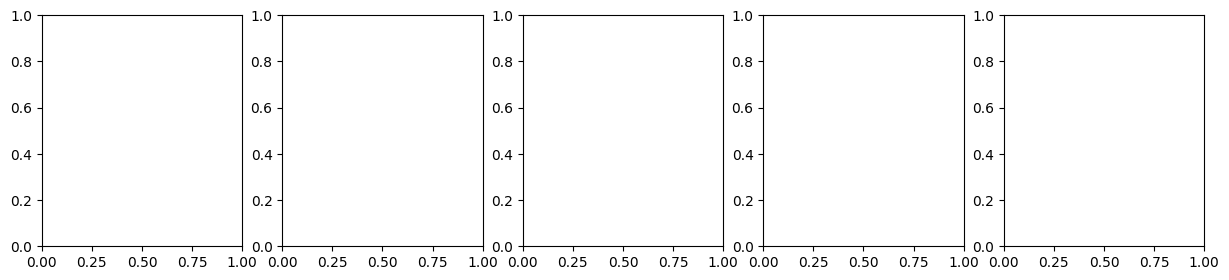

In [25]:
fig, ax = plt.subplots(1, n_sample + 1, figsize=(3 * (1 + n_sample), 3))

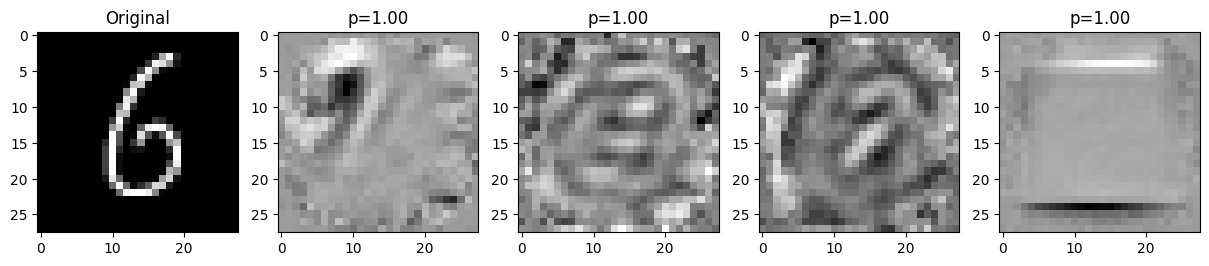

In [26]:
fig, ax = plt.subplots(1, n_sample + 1, figsize=(3 * (1 + n_sample), 3))

ax[0].imshow(d.view(28, 28).numpy(), cmap="gray")
ax[0].set_title("Original")

for k, i in enumerate(o[-n_sample:].numpy()):
    f = model.W[i].view(28, 28).data.numpy()
    ax[k + 1].imshow(f, cmap="gray")
    ax[k + 1].set_title("p=%.2f" % V[0][i].item())